In [199]:
import glob
import os
import scipy.io
import networkx as nx
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the path to the resources folder
folder_path = 'resources/'

# Find all .mat files in the resources folder
file_paths = glob.glob(folder_path + '*.mat')

flow = scipy.io.loadmat(os.path.join(folder_path,'flow.mat'))["flow"].reshape(28,)
capacities = scipy.io.loadmat(os.path.join(folder_path,'capacities.mat'))["capacities"].reshape(28,)
traffic = scipy.io.loadmat(os.path.join(folder_path,'traffic.mat'))["traffic"]
traveltime = scipy.io.loadmat(os.path.join(folder_path,'traveltime.mat'))["traveltime"].reshape(28,)

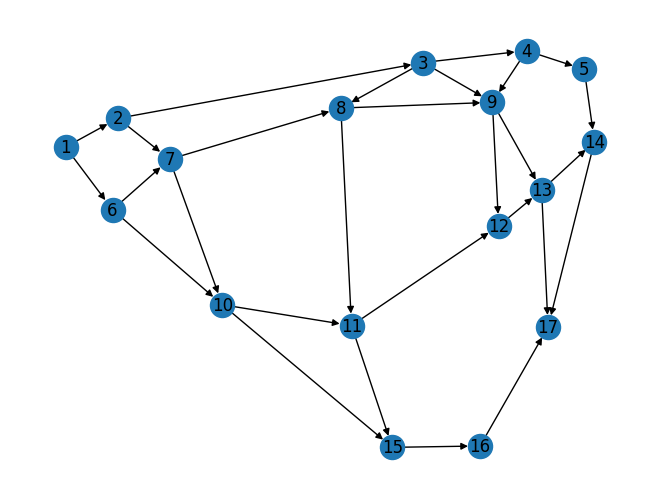

In [200]:
# Create an empty graph
G = nx.DiGraph()

# Get the number of nodes and links from the shape of B
num_nodes, num_links = traffic.shape

# Add edges to the graph based on the node-link incidence matrix
for link in range(num_links):
    tail_node = None
    head_node = None
    for node in range(num_nodes):
        if traffic[node, link] == 1:
            tail_node = node
        elif traffic[node, link] == -1:
            head_node = node
    if tail_node is not None and head_node is not None:
        edge = (tail_node+1, head_node+1)
        attr = {'capacity': capacities[link], 'traveltime': traveltime[link], 'flow': flow[link]}
        G.add_edge(*edge, **attr)

# visualize it
pos = nx.spectral_layout(G, weight='traveltime')
nx.draw(G, with_labels=True, pos=pos)

In [201]:
# (a) Find the shortest path using Dijkstra's algorithm
shortest_path = nx.dijkstra_path(G, source=1, target=17, weight='traveltime')

# Print the shortest path
print("Shortest path:", shortest_path)

Shortest path: [1, 2, 3, 9, 13, 17]


In [202]:
# (b) Find the maximum flow between node 1 and 17
max_flow_value, max_flow_dict = nx.maximum_flow(G, 1, 17)

# Print the maximum flow value
print("Maximum flow:", max_flow_value)

Maximum flow: 22448


In [203]:
# (c) Given the flow vector in flow.mat, compute the external inflow ν satisfying Bf = ν.

# Calculate the matrix product Bf
v = traffic @ flow

# Print the external inflow ν
print("External inflow v:", *v)

External inflow v: 16282 9094 19448 4957 -746 4768 413 -2 -5671 1169 -5 -7131 -380 -7412 -7810 -3430 -23544


In [204]:
# (d) Find the social optimum flow from node 1 to node 17.
# Consider that you have to minimize the function of cost.

# Use cvxpy to solve the optimization problem: minimize the cost function.
# The constraints are:
# 1. The flow should be => 0.
# 2. The flow should be <= capacities.
# 3. The flow should satisfy: traffic @ flow = [v[0], ..., v[-1]] = nu.

# Define the exogenous inflow.
exogenous_inflow = np.array([v[0], *[0]*v[1:-1].size, -v[0]])

# Define the variables.
variable_flow = cp.Variable(num_links)

# Define the constraints.
constraints = [
    variable_flow >= 0,
    variable_flow <= capacities,
    traffic @ variable_flow == exogenous_inflow
]

# Define the cost function.
cost = cp.sum(
    cp.multiply(
        cp.inv_pos(1 - variable_flow/capacities) - 1,
        traveltime*capacities
    )
)

# Define the objective function.
objective = cp.Minimize(cost)

# Define the problem.
problem = cp.Problem(objective, constraints)

# Solve the problem.
cost_opt = problem.solve(solver=cp.CLARABEL)

# Print the optimal flow.
print("Optimal flow:", variable_flow.value)

# Print the cost of the optimal flow.
print("Cost of the optimal flow:", cost_opt)


Optimal flow: [6.45395067e+03 5.91921912e+03 2.99536847e+03 2.99536148e+03
 9.82804933e+03 4.49779358e+03 2.89751871e+03 2.43625410e+03
 3.04732610e+03 5.34731546e+02 8.59914090e-02 2.92376466e+03
 6.99113927e-03 2.99536148e+03 5.33025576e+03 2.73093110e+03
 4.73433107e+03 2.13500641e+03 4.61350602e+02 2.31269965e+03
 3.19227402e+03 5.50497366e+03 2.31038879e+03 7.68932085e-03
 6.24191097e+03 5.30575027e+03 4.73433876e+03 4.73433876e+03]
Cost of the optimal flow: 23835.487462343524
